In [2]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import report_and_eval
import pickle
import logging
import performance_and_feature_importance_stability as stability_utils
logging.basicConfig(
            format='%(asctime)s %(levelname)-8s %(message)s',
            level=logging.INFO,
            datefmt='%Y-%m-%d %H:%M:%S')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Set your W&B API key or configure it in your environment
import wandb
wandb.login()

%load_ext autoreload
%autoreload 2

2024-04-12 18:34:31 ERROR    Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: millergw. Use `wandb login --relogin` to force relogin


# TODO:
- [ ] examine stability of P-NET layers
- [ ] try adding germline (and additional data aka confounders) to RF, BDT models. Prioritize the BDT since it is more promising.

In [3]:
# DATADIR = '/mnt/disks/pancan' # Marc's
# DATADIR = '../../pnet_germline/data' # Gwen's
# SAVEDIR = '../../pnet/results/gene_rank_stability' # Gwen's (before Mark improved stability)
PNET_DIR = '../../pnet/results/gene_rank_stability_v2' # Gwen's (after Mark improved stability)
BDT_DIR = '../../pnet/results/somatic_bdt_eval_set_test'
RF_DIR = '../../pnet/results/somatic_rf_eval_set_test'
ARXIV_PNET_DIR = '../../cancer-net/reprod_report' # Gwen's (after Mark improved stability)

FIGDIR = '../figures/'

# Relative performance
TODO:
- load RF, BDT data from W&B.
- load P-NET data from pickle files.
- make standardized DF for plotting (rows = runs, columns = model type, values = performance metric)

## Arxiv GAN reproduction

In [91]:
api = wandb.Api()

# Replace 'your_username', 'your_project', and 'your_group_name' with your actual username, project name, and group name
runs = api.runs("millergw/init_variance", filters={"sweep": "9sob1jgy", "state": "Finished"})

# Initialize empty lists for each metric
aucs = []
accs = []
auprs = []
f1_scores = []
precisions = []
recalls = []

for run in runs:
    d = run.summary_metrics
    aucs.append(d['test auc'])
    accs.append(d['test acc'])
    auprs.append(d['test aupr'])
    f1_scores.append(d['test f1'])
    precisions.append(d['test precision'])
    recalls.append(d['test recall'])

# Create a new dictionary with metric lists
arxiv_gcn_metrics_dict = {
    'auc': aucs,
    'acc': accs,
    'aupr': auprs,
    'f1': f1_scores,
    'precision': precisions,
    'recall': recalls
}

logging.info(f"Computing performance metric stats using data from {len(runs)} runs")
for k, v in arxiv_gcn_metrics_dict.items():
    print("Arxiv GCN %s: %.2f +/- %.2f" % (k, np.mean(v), np.std(v)))

2024-04-12 20:06:25 INFO     Computing performance metric stats using data from 21 runs


Arxiv GCN auc: 0.91 +/- 0.00
Arxiv GCN acc: 0.81 +/- 0.02
Arxiv GCN aupr: 0.82 +/- 0.01
Arxiv GCN f1: 0.61 +/- 0.06
Arxiv GCN precision: 0.92 +/- 0.03
Arxiv GCN recall: 0.46 +/- 0.06


## Arxiv P-NET reproduction

In [92]:
logging.info("Grabbing the performance metrics for arxiv P-NET from saved pickle file")
# with open(os.path.join(ARXIV_PNET_DIR, 'pnet_results.h6.torch.num_workers_16.pkl'), 'rb') as file:
with open(os.path.join(ARXIV_PNET_DIR, 'pnet_results.h6.torch.pkl'), 'rb') as file:
    arxiv_pnet_results = pickle.load(file)

arxiv_pnet_results[0].keys()
# arxiv_pnet_aucs = arxiv_pnet_results['auc']
# arxiv_pnet_aucs

2024-04-12 20:06:35 INFO     Grabbing the performance metrics for arxiv P-NET from saved pickle file


dict_keys(['auc', 'accuracy', 'aupr', 'f1', 'precision', 'recall', 'pred', 'y'])

In [93]:
# Initialize empty lists for each metric
aucs = []
accs = []
auprs = []
f1_scores = []
precisions = []
recalls = []

# Iterate over each dictionary in the list and extract metric values
for d in arxiv_pnet_results:
    aucs.append(d['auc'])
    accs.append(d['accuracy'])
    auprs.append(d['aupr'])
    f1_scores.append(d['f1'])
    precisions.append(d['precision'])
    recalls.append(d['recall'])

# Create a new dictionary with metric lists
arxiv_pnet_metrics_dict = {
    'auc': aucs,
    'acc': accs,
    'aupr': auprs,
    'f1': f1_scores,
    'precision': precisions,
    'recall': recalls
}

# Now metrics_dict contains the desired structure with lists of metric values
logging.info(f"Computing performance metric stats using data from {len(arxiv_pnet_results)} runs")
for k, v in arxiv_pnet_metrics_dict.items():
    print("Arxiv P-NET %s: %.2f +/- %.2f" % (k, np.mean(v), np.std(v)))

2024-04-12 20:06:40 INFO     Computing performance metric stats using data from 22 runs


Arxiv P-NET auc: 0.94 +/- 0.02
Arxiv P-NET acc: 0.86 +/- 0.06
Arxiv P-NET aupr: 0.89 +/- 0.04
Arxiv P-NET f1: 0.72 +/- 0.23
Arxiv P-NET precision: 0.81 +/- 0.26
Arxiv P-NET recall: 0.65 +/- 0.21


## BDT, RF, and Marc's torch P-NET

In [94]:
logging.info("Grabbing the performance metrics for BDT and RF from W&B")
# Specify your project and run group
entity = "millergw"
project_name = "prostate_met_status"
run_group = "bdt_stability_experiment_004"
metric = "test_roc_auc_score"
bdt_eval_auc = stability_utils.get_summary_metric_from_wandb(entity, project_name, metric, run_group=run_group)
print("BDT AUC:", np.mean(bdt_eval_auc))

# Specify your project and run group
run_group = "rf_stability_experiment_003"
metric = "test_roc_auc_score"
rf_eval_auc = stability_utils.get_summary_metric_from_wandb(entity, project_name, metric, run_group=run_group)
print("RF AUC:", np.mean(rf_eval_auc))

logging.info("Grabbing the performance metrics for P-NET from saved pickle file")
# Read gene_imps from a Pickle file (format: len 20 list --> pandas DFs, samples x genes?)
with open(os.path.join(PNET_DIR, 'aucs.pkl'), 'rb') as file:
    pnet_aucs = pickle.load(file)
print("P-NET AUC:", np.mean(pnet_aucs))

2024-04-12 20:06:46 INFO     Grabbing the performance metrics for BDT and RF from W&B
2024-04-12 20:06:48 INFO     Grabbing the performance metrics for P-NET from saved pickle file


BDT AUC: 0.9272815743944637
RF AUC: 0.8754000865051903
P-NET AUC: 0.8948529411764706


In [116]:
logging.info("Constructing a DF of AUCs")
auc_df = pd.DataFrame({
    'Group': ['P-NET'] * len(pnet_aucs) +
             ['RF'] * len(rf_eval_auc) +
             ['BDT'] * len(bdt_eval_auc) +
             ['arxiv P-NET (h=6)'] * len(arxiv_pnet_metrics_dict['auc']) +
             ['arxiv GCN'] * len(arxiv_gcn_metrics_dict['auc']),
    'Value': pnet_aucs + rf_eval_auc + bdt_eval_auc + arxiv_pnet_metrics_dict['auc'] + arxiv_gcn_metrics_dict['auc']
})

logging.debug("Sorting model order by decreasing mean")
# Calculate the mean of each group
group_means = auc_df.groupby('Group')['Value'].mean().sort_values(ascending=False)

# Reorder the DataFrame based on the descending group means
auc_df = auc_df.set_index('Group').loc[group_means.index].reset_index()
grouped_auc_df = auc_df.groupby('Group')
display(auc_df)


2024-04-12 20:14:49 INFO     Constructing a DF of AUCs


,Group,Value
0,arxiv P-NET (h=6),0.932093
1,arxiv P-NET (h=6),0.945934
2,arxiv P-NET (h=6),0.942907
3,arxiv P-NET (h=6),0.869810
4,arxiv P-NET (h=6),0.942042
...,...,...
98,RF,0.886678
99,RF,0.861808
100,RF,0.868728
101,RF,0.872189


In [117]:
print("mean\n",auc_df.mean())
print("median\n",auc_df.median())
print("stdev\n",auc_df.std())

mean
 Value    0.909138
dtype: float64
median
 Value    0.912197
dtype: float64
stdev
 Value    0.024532
dtype: float64


/var/tmp/ipykernel_23667/1180494351.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("mean\n",auc_df.mean())
/var/tmp/ipykernel_23667/1180494351.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("median\n",auc_df.median())
/var/tmp/ipykernel_23667/1180494351.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("stdev\n",auc_df.std())


In [119]:
# print("mean\n",auc_df.mean())
# print("median\n",auc_df.median())
# print("stdev\n",auc_df.std())
# display(auc_df.groupby('Group').median())
display(grouped_auc_df.median())
display(grouped_auc_df.std())

,Value
Group,
BDT,0.926254
P-NET,0.893382
RF,0.875433
arxiv GCN,0.911765
arxiv P-NET (h=6),0.942474


,Value
Group,
BDT,0.002486
P-NET,0.014910
RF,0.008274
arxiv GCN,0.004948
arxiv P-NET (h=6),0.017158


2024-04-12 20:15:15 INFO     saving plot to ../figures/pnet_gcn_arxivPnet_rf_bdt_performance_benchmark_AUC_w_points


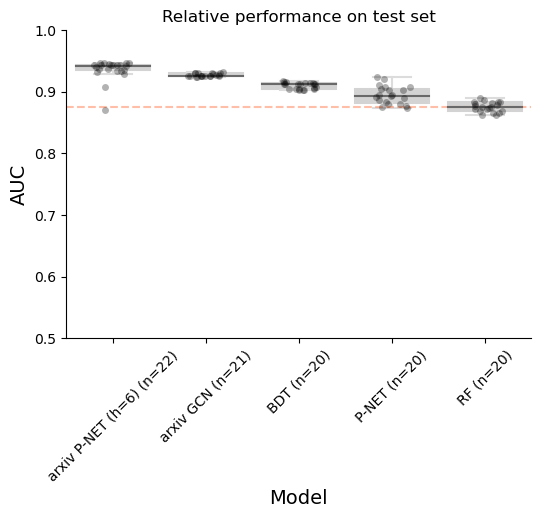

2024-04-12 20:15:16 INFO     saving plot to ../figures/pnet_gcn_arxivPnet_rf_bdt_performance_benchmark_AUC


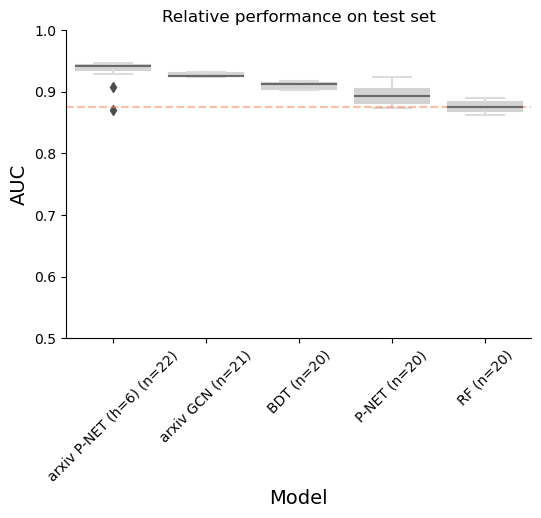

In [120]:
# SAVENAME = 'pnet_rf_bdt_performance_benchmark_AUC_w_points'
SAVENAME = 'pnet_gcn_arxivPnet_rf_bdt_performance_benchmark_AUC_w_points'
# SAVENAME_nopoints = 'pnet_rf_bdt_performance_benchmark_AUC'
SAVENAME_nopoints = 'pnet_gcn_arxivPnet_rf_bdt_performance_benchmark_AUC'

smallest_median_val = auc_df.groupby('Group').median().min().min()

# Set up the boxplot with points using Seaborn
plt.figure(figsize=(6, 4))
sns.boxplot(x='Group', y='Value',
    data=auc_df, color='gray', showfliers=False, boxprops={'facecolor': 'lightgrey', 'color': 'lightgrey'},
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                      medianprops={'color': 'dimgrey'})
sns.stripplot(x='Group', y='Value', data=auc_df, color='black', jitter=0.2, alpha=0.3)

# Customize plot appearance
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.axhline(y=smallest_median_val, color='coral', linestyle='--', label=f'y_min = {smallest_median_val}', alpha=0.5)

# Calculate the number of samples in each group
sample_counts = auc_df['Group'].value_counts()
# Create custom x-axis labels with sample counts
x_labels = [f"{group} (n={sample_counts[group]})" for group in sample_counts.index]
plt.xticks(range(len(sample_counts.index)), x_labels, rotation=45)

ax.set_ylabel('AUC', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylim((0.5, 1))
plt.title("Relative performance on test set")
report_and_eval.savefig(plt, os.path.join(FIGDIR, SAVENAME), png=True, pdf=True)
plt.show()



# Set up the boxplot WITHOUT points using Seaborn
plt.figure(figsize=(6, 4))
sns.boxplot(x='Group', y='Value',
    data=auc_df, color='gray', showfliers=True, boxprops={'facecolor': 'lightgrey', 'color': 'lightgrey'},
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                      medianprops={'color': 'dimgrey'})

# Customize plot appearance
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.axhline(y=smallest_median_val, color='coral', linestyle='--', label=f'y_min = {smallest_median_val}', alpha=0.5)

# Calculate the number of samples in each group
sample_counts = auc_df['Group'].value_counts()
# Create custom x-axis labels with sample counts
x_labels = [f"{group} (n={sample_counts[group]})" for group in sample_counts.index]
plt.xticks(range(len(sample_counts.index)), x_labels, rotation=45)


ax.set_ylabel('AUC', size=14)
ax.set_xlabel('Model', size=14)
ax.set_ylim((0.5, 1))
plt.title("Relative performance on test set")
report_and_eval.savefig(plt, os.path.join(FIGDIR, SAVENAME_nopoints), png=True, pdf=True)
plt.show()



# Relative stability of feature importance
- have gene-level for P-NET, RF, and BDT
- also have layer/pathway level information for P-NET

In [10]:
import pickle

# Read gene_imps from a Pickle file (format: len 20 list --> pandas DFs, samples x genes?)
with open(os.path.join(PNET_DIR, 'gene_imps.pkl'), 'rb') as file:
    gene_imps = pickle.load(file)

# Read layerwise_imps from a Pickle file (format: len 20 list --> len 5 list --> pandas DF, samples x features)
with open(os.path.join(PNET_DIR, 'layerwise_imps.pkl'), 'rb') as file:
    layerwise_imps = pickle.load(file)

In [11]:
[i.shape for i in layerwise_imps[0]]

[(102, 734), (102, 845), (102, 449), (102, 159), (102, 29)]

2024-01-31 18:29:49 INFO     Calculating patient-level stability metric
2024-01-31 18:29:49 INFO     Plotting histogram of patient-level stability metric


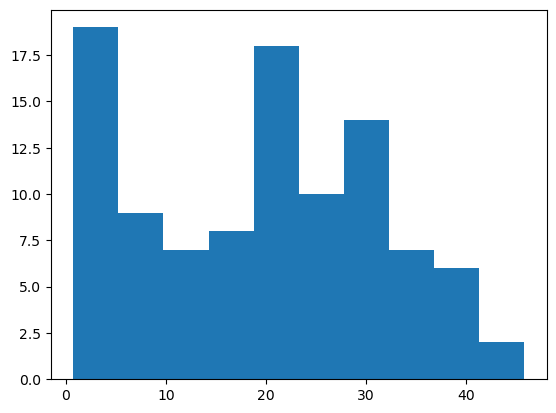

In [12]:
pnet_gene_imps = stability_utils.get_pnet_gene_imps(PNET_DIR)
pnet_patient_stabs = stability_utils.calc_perpatient_stability_metric(pnet_gene_imps)

logging.info("Plotting histogram of patient-level stability metric")
# median stdev of top 50 genes (top 50 relative to each patient). 
# Pretty darn unstable. 
# For example, a gene at rank 50 with a stdev of 50 means that 68% of the time, its rank was between 0 and 100.
plt.hist(pnet_patient_stabs)
plt.show()

In [5]:
MODEL_TYPE = "rf"
EVAL_SET = 'test' # val, validation
SAVEDIR = f'../../pnet/results/somatic_{MODEL_TYPE}_eval_set_{EVAL_SET}' # Gwen's

rf_gene_imps = stability_utils.get_sklearn_feature_imps(SAVEDIR)

In [6]:
# PROBLEM: RF and BDT don't have per-patient feature importances. How did Marc deal with this? He said that he normally grouped by the response variable.
# Maybe I'll just look at the overall model-level stability here. That'll be easiest to compare anyway. :/
print(type(pnet_gene_imps[0]))
print(type(rf_gene_imps[0]))

NameError: name 'pnet_gene_imps' is not defined

In [ ]:
rf_model_stability = stability_utils.calc_model_stability(rf_gene_imps, n_top_genes=50)
rf_model_stability

/var/tmp/ipykernel_21552/3316825710.py:204: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn("TODO: check functionality. Is the rankings DF correct?")
2024-01-31 18:29:54 WARNING  TODO: check functionality. Is the rankings DF correct?
2024-01-31 18:29:54 INFO     Convert to rank and sort


2024-01-31 18:29:54 INFO     Compute the average and standard deviation across rows (aka runs)


14.514698846941538

In [ ]:
pd.DataFrame(rf_gene_imps).apply(lambda row: row.abs().rank(ascending=False).sort_values(), axis=1)

,A1CF_somatic_amp,A1CF_somatic_del,A1CF_somatic_mut,AADAC_somatic_amp,AADAC_somatic_del,AADAC_somatic_mut,AAMP_somatic_amp,AAMP_somatic_del,AAMP_somatic_mut,AASDH_somatic_amp,...,ZW10_somatic_mut,ZYG11B_somatic_amp,ZYG11B_somatic_del,ZYG11B_somatic_mut,ZYX_somatic_amp,ZYX_somatic_del,ZYX_somatic_mut,ZZZ3_somatic_amp,ZZZ3_somatic_del,ZZZ3_somatic_mut
0,443.0,10702.0,1447.0,524.0,10702.0,10702.0,10702.0,10702.0,10702.0,10702.0,...,3609.0,10702.0,10702.0,10702.0,6162.0,10702.0,10702.0,10702.0,10702.0,3660.0
1,4418.5,10676.5,1286.0,3914.0,10676.5,10676.5,10676.5,10676.5,4225.0,5723.5,...,10676.5,10676.5,10676.5,10676.5,1409.0,10676.5,10676.5,10676.5,3218.0,10676.5
2,158.0,10702.0,735.0,661.0,10702.0,10702.0,4278.5,10702.0,10702.0,10702.0,...,1279.0,10702.0,10702.0,10702.0,5727.0,10702.0,10702.0,6034.0,10702.0,4756.0
3,10673.5,3760.0,2148.0,1684.0,10673.5,10673.5,10673.5,10673.5,10673.5,10673.5,...,3515.0,10673.5,10673.5,10673.5,2999.0,4642.0,10673.5,10673.5,4496.0,10673.5
4,2328.0,10698.5,2182.0,1157.0,10698.5,10698.5,10698.5,10698.5,5798.0,10698.5,...,3606.0,10698.5,10698.5,10698.5,6007.0,10698.5,10698.5,10698.5,4331.0,10698.5
5,363.0,10718.5,4740.0,2612.0,10718.5,10718.5,10718.5,10718.5,10718.5,10718.5,...,1760.0,10718.5,4938.0,10718.5,4483.5,10718.5,10718.5,6229.0,3286.0,10718.5
6,325.0,10662.0,2224.0,531.0,10662.0,10662.0,1430.0,2370.0,10662.0,3647.0,...,10662.0,10662.0,10662.0,10662.0,4645.0,10662.0,10662.0,10662.0,4373.0,10662.0
7,911.0,10662.5,839.0,2026.0,677.0,10662.5,1218.0,3574.0,10662.5,10662.5,...,3558.0,10662.5,1717.0,10662.5,6410.0,4905.0,10662.5,10662.5,10662.5,10662.5
8,10667.0,10667.0,1032.0,3449.0,5185.0,10667.0,10667.0,10667.0,10667.0,5619.0,...,2475.0,10667.0,5462.5,10667.0,6172.0,10667.0,1813.0,5437.0,5650.0,10667.0
9,1544.0,10668.0,5108.0,5342.0,2751.0,10668.0,10668.0,10668.0,10668.0,10668.0,...,3848.0,10668.0,10668.0,10668.0,1861.0,10668.0,1704.0,3287.0,2128.0,5742.0


In [18]:
# TODO: create sorted DF across all runs
for i in range(len(rf_gene_imps)):
    print(f"Run {i}")
    print(rf_gene_imps[i].rank(ascending=False).sort_values()[:10])
    print("\n")

Run 0
AR_somatic_amp           1.0
AR_somatic_mut           2.0
PTEN_somatic_del         3.0
TP53_somatic_mut         4.0
TSPYL5_somatic_amp       5.0
PDGFA_somatic_amp        6.0
ADAMTS12_somatic_mut     7.0
PDE4DIP_somatic_mut      8.0
GABRA6_somatic_mut       9.0
SCAP_somatic_mut        10.0
dtype: float64


Run 1
AR_somatic_amp        1.0
AR_somatic_mut        2.0
TP53_somatic_mut      3.0
PTEN_somatic_del      4.0
PREX2_somatic_mut     5.0
PDGFA_somatic_amp     6.0
UNC5B_somatic_amp     7.0
SCAP_somatic_mut      8.0
LRP2_somatic_mut      9.0
PXDNL_somatic_mut    10.0
dtype: float64


Run 2
AR_somatic_amp         1.0
AR_somatic_mut         2.0
TP53_somatic_mut       3.0
PTEN_somatic_del       4.0
PDGFA_somatic_amp      5.0
FCHSD1_somatic_mut     6.0
TSPYL5_somatic_amp     7.0
PREX2_somatic_mut      8.0
ZMIZ1_somatic_amp      9.0
NOM1_somatic_del      10.0
dtype: float64


Run 3
AR_somatic_amp        1.0
AR_somatic_mut        2.0
TP53_somatic_mut      3.0
PTEN_somatic_del      4.0
P

In [8]:
MODEL_TYPE = "bdt"
EVAL_SET = 'test' # val
SAVEDIR = f'../../pnet/results/somatic_{MODEL_TYPE}_eval_set_{EVAL_SET}' # Gwen's

bdt_gene_imps = stability_utils.get_sklearn_feature_imps(SAVEDIR)
bdt_model_stability = stability_utils.calc_model_stability(bdt_gene_imps, n_top_genes=50)
bdt_model_stability

/var/tmp/ipykernel_12065/3756990728.py:190: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn("TODO: check functionality. Is the rankings DF correct?")
2024-02-20 22:50:45 WARNING  TODO: check functionality. Is the rankings DF correct?
2024-02-20 22:50:45 INFO     Convert to rank and sort
2024-02-20 22:50:45 INFO     Compute the average and standard deviation across rows (aka runs)


2.392972166464475

In [19]:
## Here we create a runs x feature rank DF (values = feature name). This is useful for comparing across runs. The input was a list of series, where each series is the gene imp list from a given run.
# Create a DataFrame to store the ranks
rank_df = pd.DataFrame()
tmp_ranks = []
series_list = bdt_gene_imps
# series_list = rf_gene_imps
# Iterate through each series, calculate ranks, and add to the DataFrame
for i in range(len(series_list)):
    series = series_list[i]
    # Calculate ranks and convert them to integers
    ranks = series.abs().rank(ascending=False, method='dense').astype(int).sort_values()
    tmp_ranks.append(ranks.index.tolist())
    # Add ranks to the DataFrame
    # rank_df[series.name] = ranks

# Display the resulting DataFrame
N = 10
rank_df = pd.DataFrame(tmp_ranks)
display(rank_df.loc[:,:N])

print(rank_df.loc[:,:N].stack().value_counts())
top_unique_features = rank_df.loc[:,:N].stack().unique()
print([i.split("_")[0] for i in top_unique_features])
print(len(top_unique_features))


# Display a gene x rank DF (value = # times that gene had that rank across the N=20 runs)
top_gene_by_rank_consistency_df = rank_df.loc[:,:N].apply(lambda col: col.value_counts()).fillna('').reindex(top_unique_features)
display(top_gene_by_rank_consistency_df)

,0,1,2,3,4,5,6,7,8,9,10
0,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,SDAD1_somatic_mut
1,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,LRP2_somatic_mut
2,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,PPIF_somatic_amp
3,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,SDAD1_somatic_mut
4,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,SDAD1_somatic_mut
5,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,LRP2_somatic_mut
6,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,ARL14_somatic_mut,STEAP4_somatic_mut,SDAD1_somatic_mut
7,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,PPIF_somatic_amp
8,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,ARL14_somatic_mut,STEAP4_somatic_mut,SDAD1_somatic_mut
9,AR_somatic_amp,AR_somatic_mut,TP53_somatic_mut,PTEN_somatic_del,PDGFA_somatic_amp,KLHDC8A_somatic_amp,NOM1_somatic_del,FBXO4_somatic_amp,STEAP4_somatic_mut,ARL14_somatic_mut,SDAD1_somatic_mut


AR_somatic_amp         20
AR_somatic_mut         20
TP53_somatic_mut       20
PTEN_somatic_del       20
PDGFA_somatic_amp      20
KLHDC8A_somatic_amp    20
NOM1_somatic_del       20
FBXO4_somatic_amp      20
STEAP4_somatic_mut     20
ARL14_somatic_mut      20
SDAD1_somatic_mut       7
LRP2_somatic_mut        7
PPIF_somatic_amp        6
dtype: int64
['AR', 'AR', 'TP53', 'PTEN', 'PDGFA', 'KLHDC8A', 'NOM1', 'FBXO4', 'STEAP4', 'ARL14', 'SDAD1', 'LRP2', 'PPIF']
13


,0,1,2,3,4,5,6,7,8,9,10
AR_somatic_amp,20.0,,,,,,,,,,
AR_somatic_mut,,20.0,,,,,,,,,
TP53_somatic_mut,,,20.0,,,,,,,,
PTEN_somatic_del,,,,20.0,,,,,,,
PDGFA_somatic_amp,,,,,20.0,,,,,,
KLHDC8A_somatic_amp,,,,,,20.0,,,,,
NOM1_somatic_del,,,,,,,20.0,,,,
FBXO4_somatic_amp,,,,,,,,20.0,,,
STEAP4_somatic_mut,,,,,,,,,18.0,2.0,
ARL14_somatic_mut,,,,,,,,,2.0,18.0,


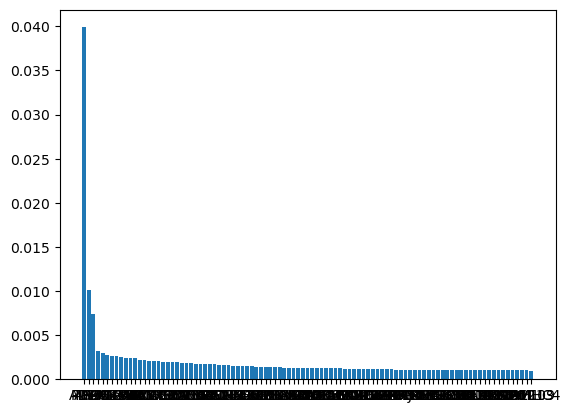

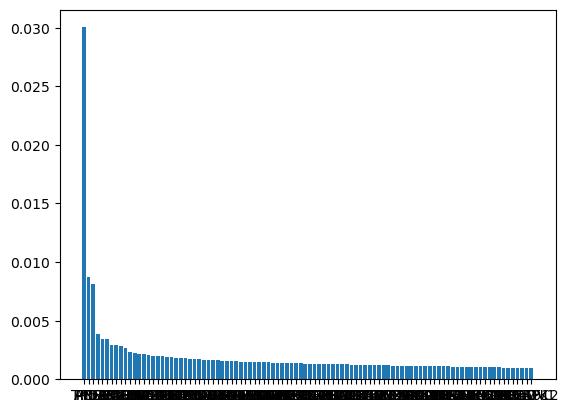

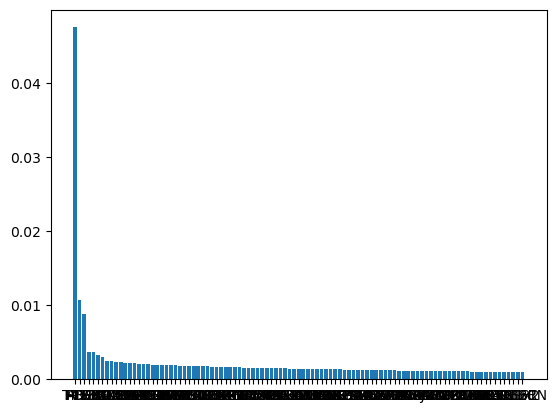

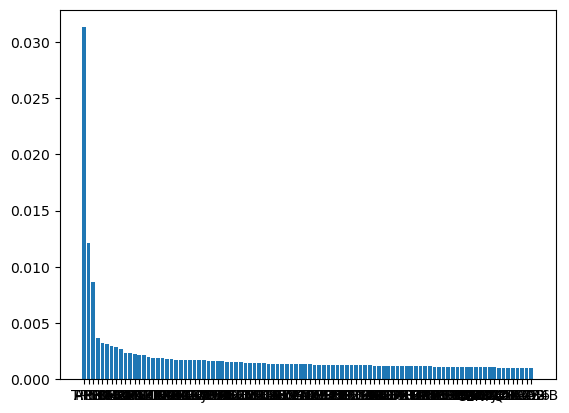

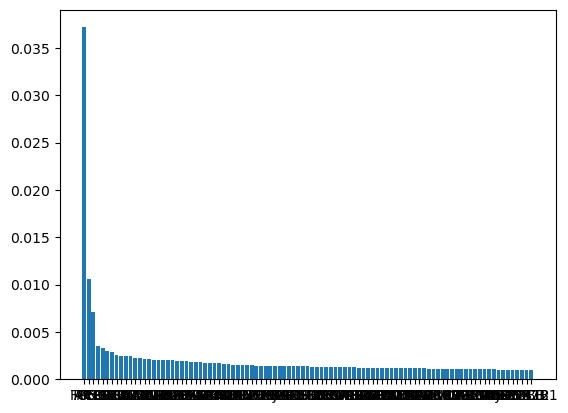

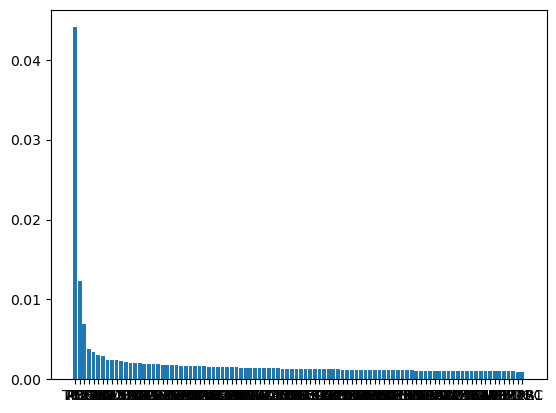

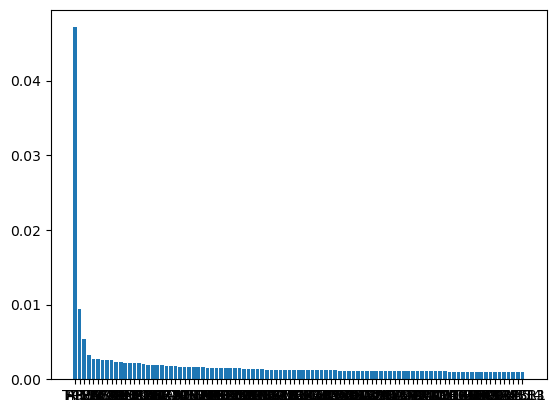

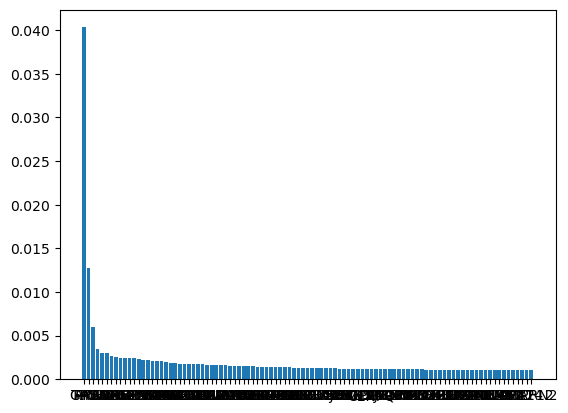

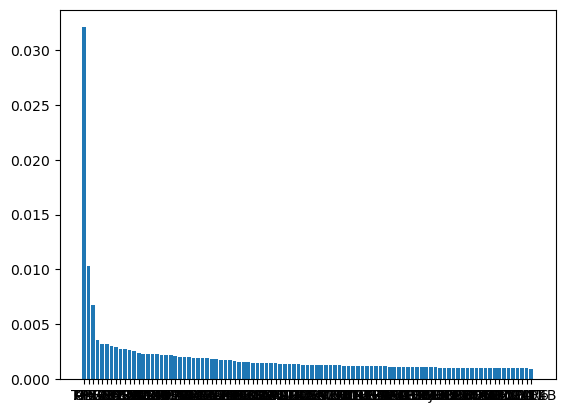

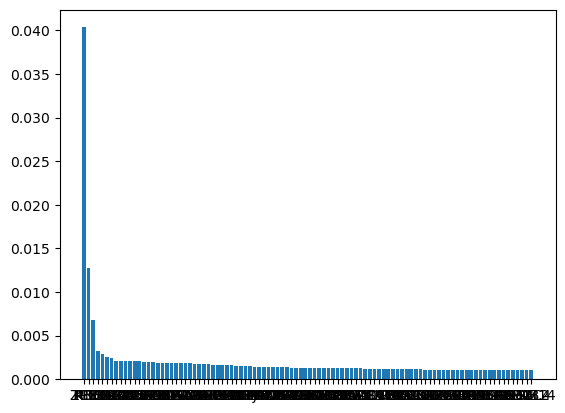

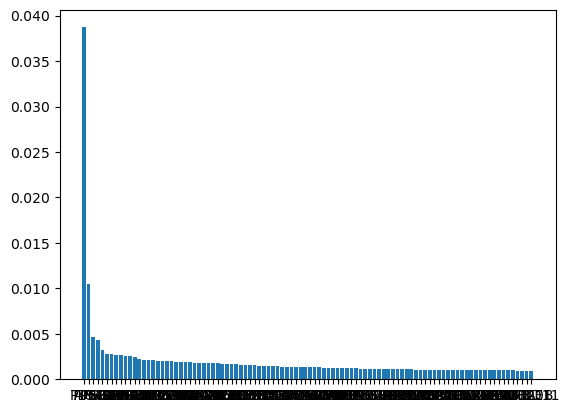

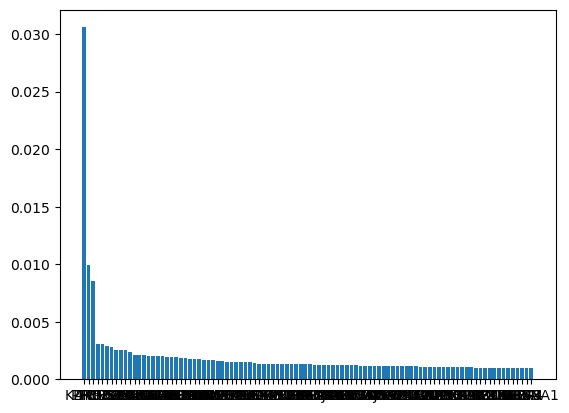

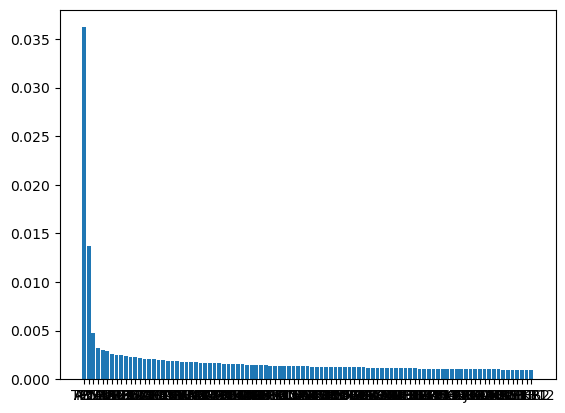

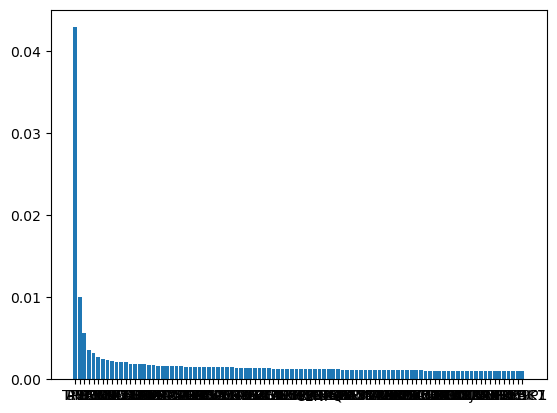

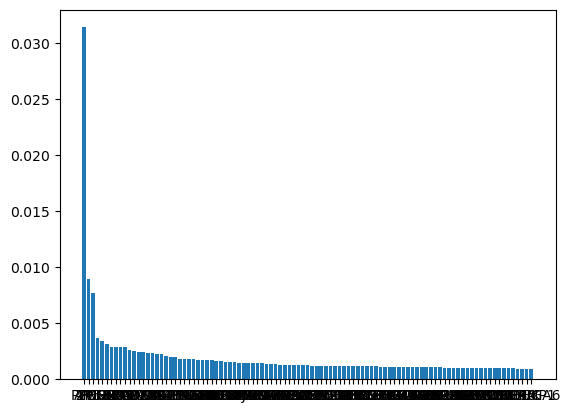

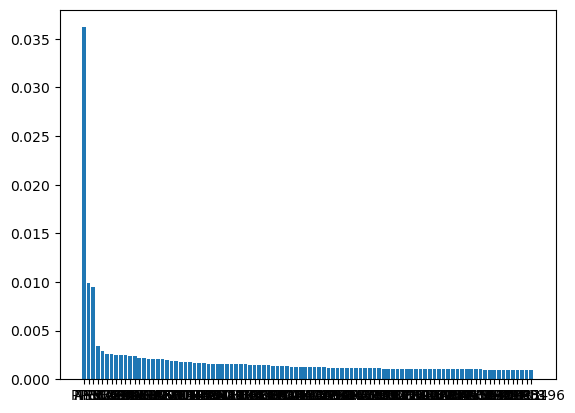

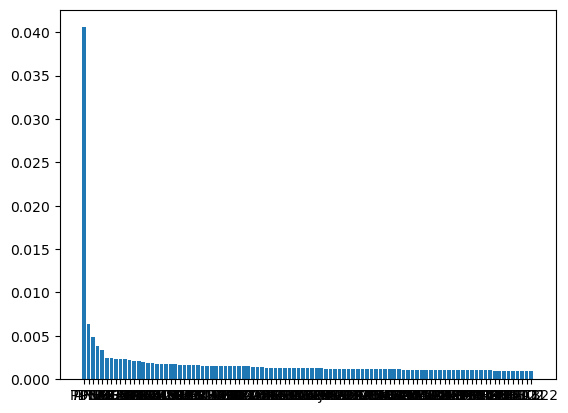

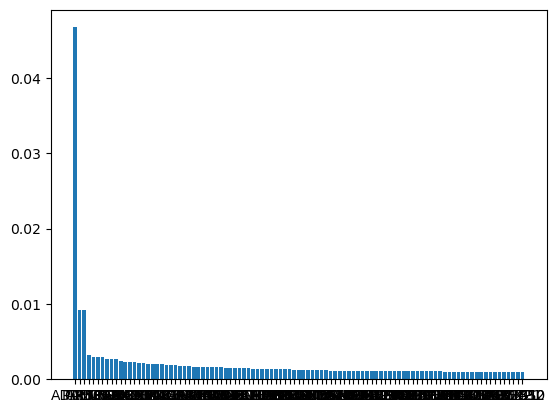

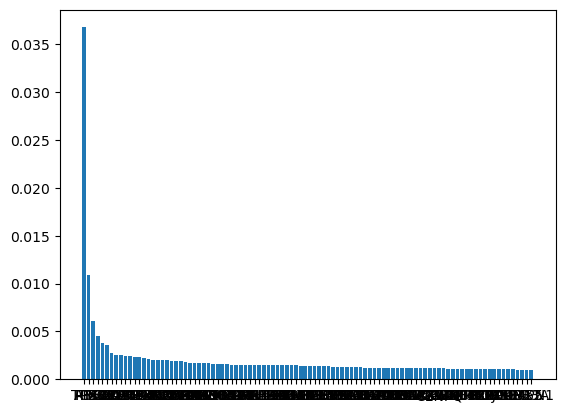

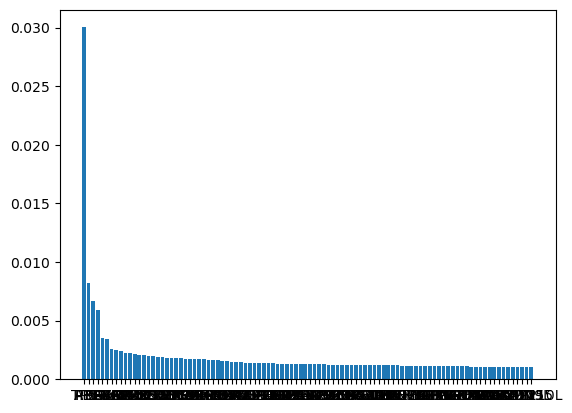

In [60]:
for run in range(len(rf_gene_imps)):
    top_rank_run1 = rf_gene_imps[run].rank(ascending=False).sort_values().index[:100]
    plt.bar([i.split('_')[0] for i in top_rank_run1], rf_gene_imps[run].loc[top_rank_run1])
    plt.show()

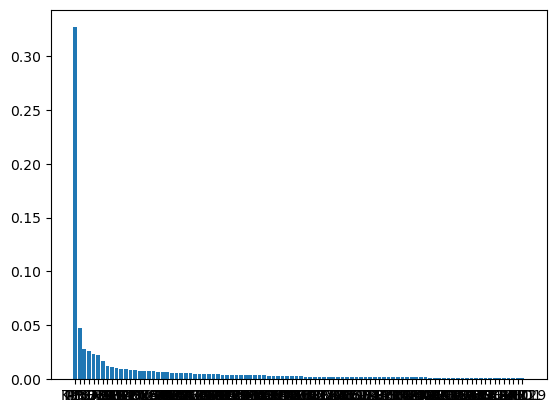

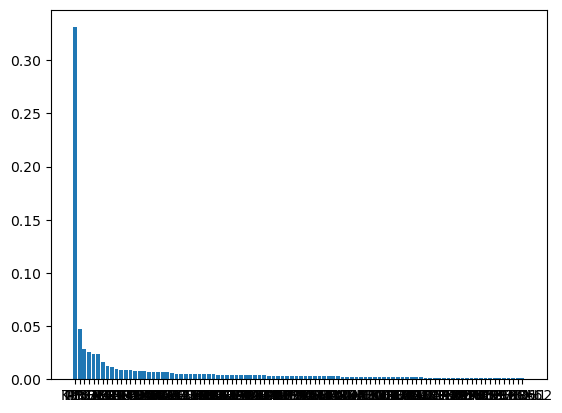

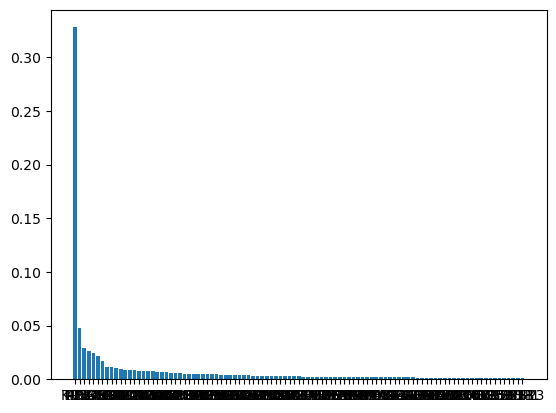

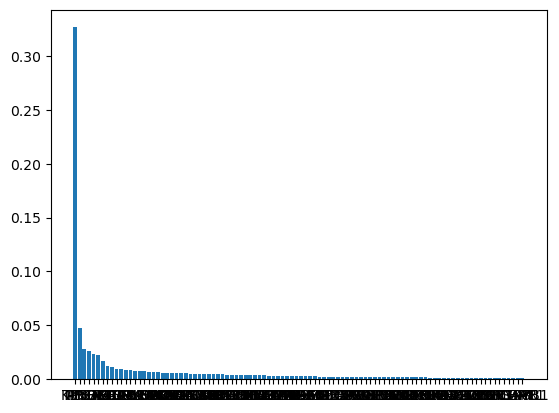

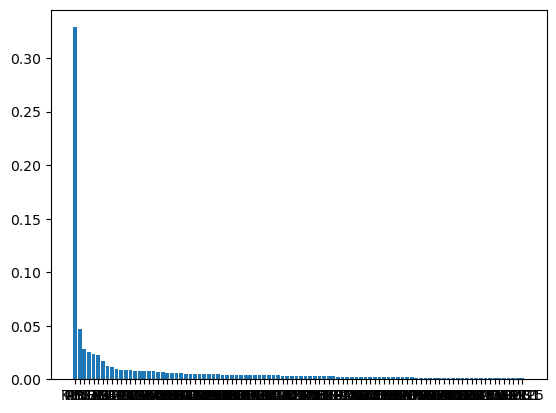

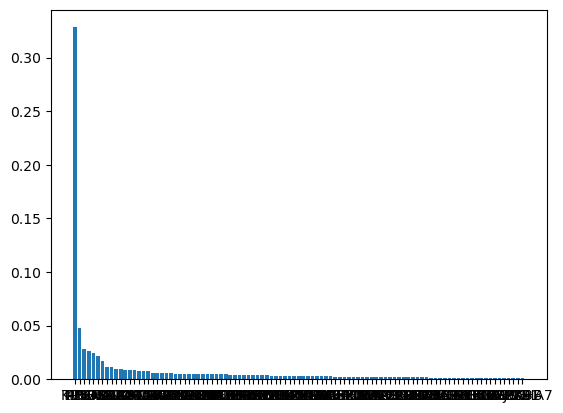

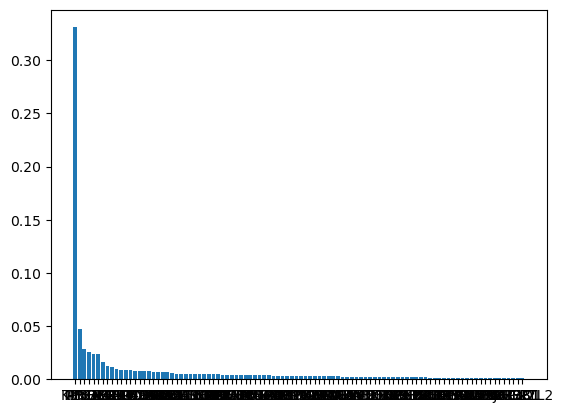

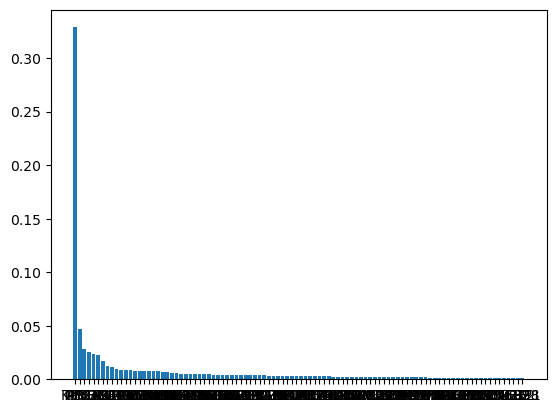

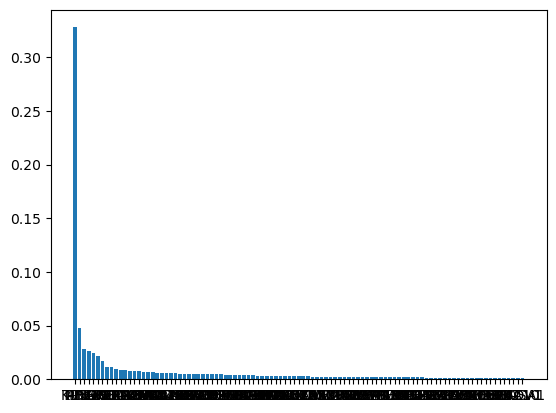

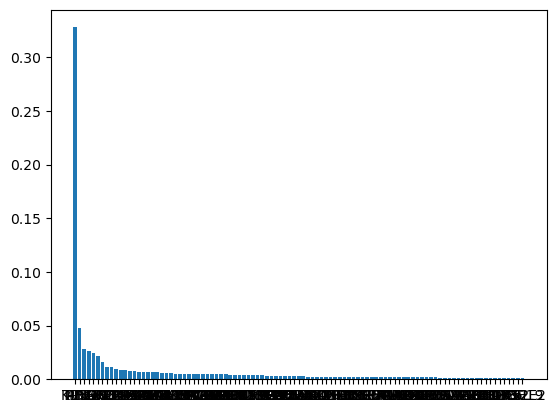

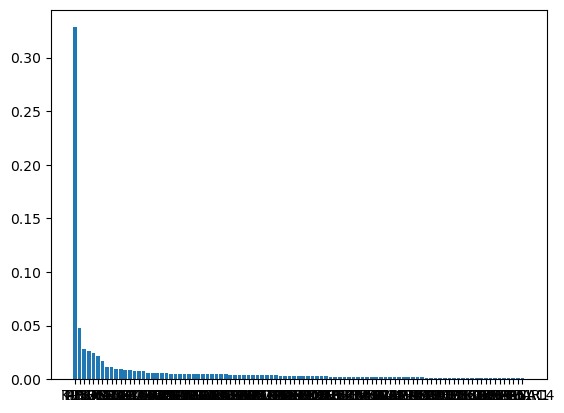

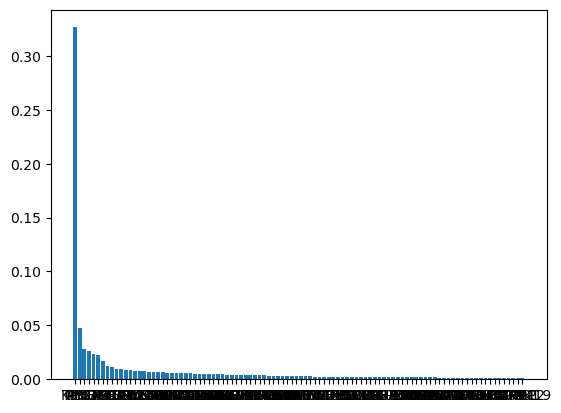

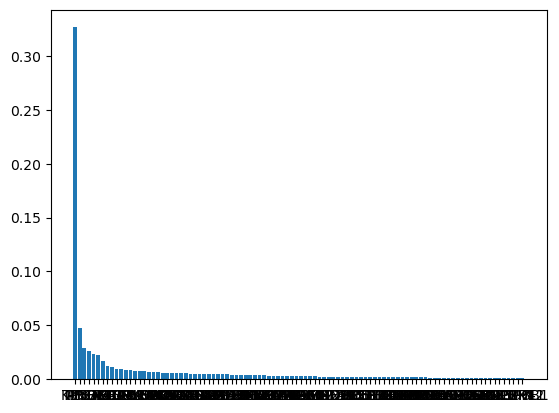

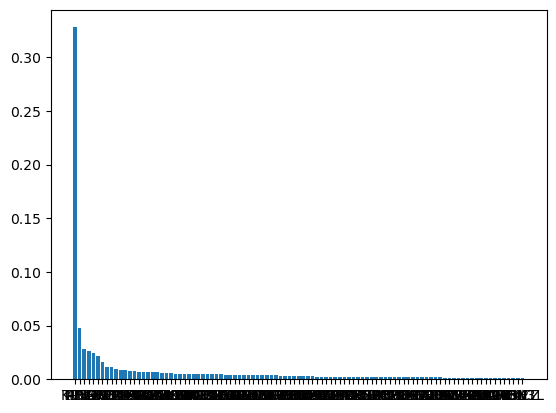

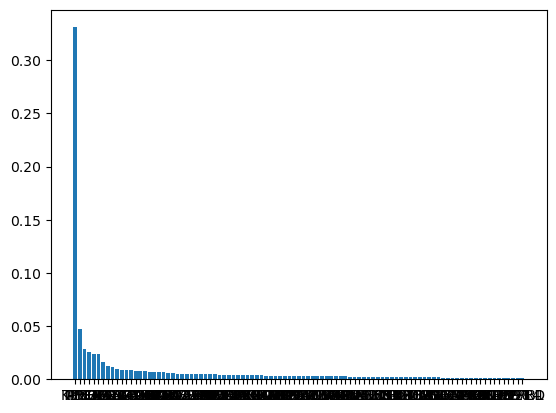

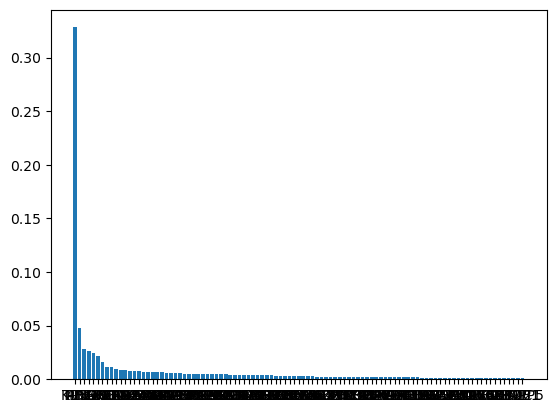

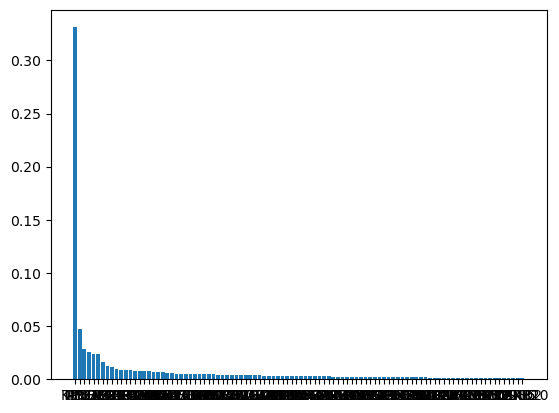

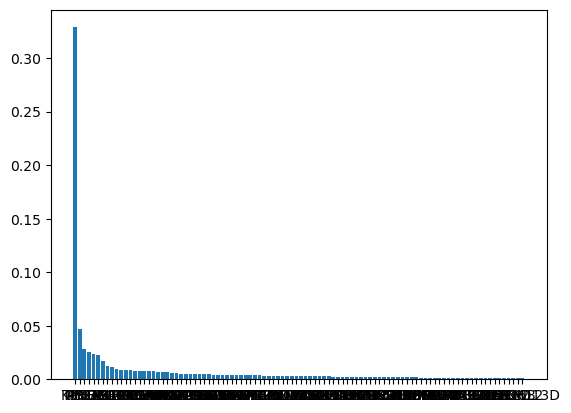

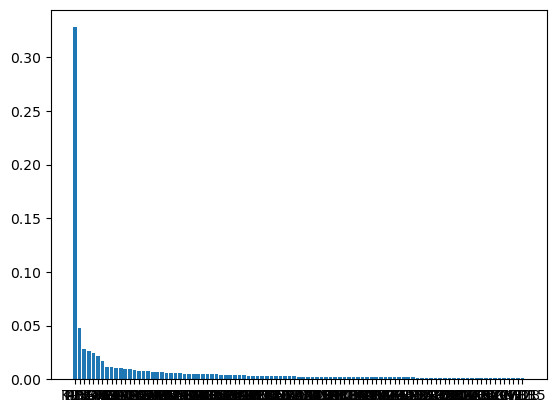

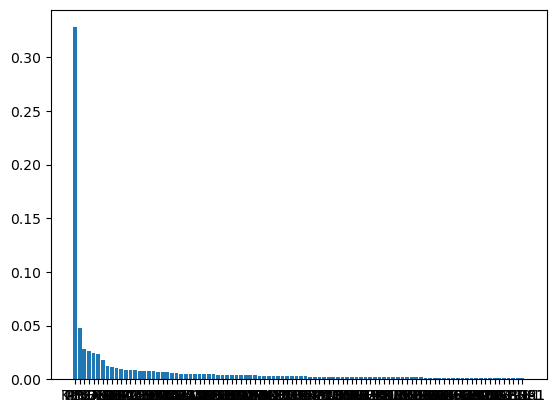

In [59]:
for run in range(len(bdt_gene_imps)):
    top_rank_run1 = bdt_gene_imps[run].rank(ascending=False).sort_values().index[:100]
    plt.bar([i.split('_')[0] for i in top_rank_run1], bdt_gene_imps[run].loc[top_rank_run1])
    plt.show()

In [97]:
logging.info("Exploring the ranks particular features of interest")
tmp = []
for run in range(len(bdt_gene_imps)):
    tmp.append(bdt_gene_imps[run].rank(ascending=False).sort_values()[
        ['MDM4_somatic_amp', 'MDM4_somatic_del', 'MDM4_somatic_mut']
        # ['FGFR1_somatic_amp', 'FGFR1_somatic_del', 'FGFR1_somatic_mut']
        ].tolist())
tmp

[[7457.5, 7457.5, 7457.5],
 [7451.5, 7451.5, 7451.5],
 [7450.5, 7450.5, 7450.5],
 [7457.0, 7457.0, 7457.0],
 [7453.0, 7453.0, 7453.0],
 [7456.0, 7456.0, 7456.0],
 [7450.5, 7450.5, 7450.5],
 [7452.0, 7452.0, 7452.0],
 [7452.5, 7452.5, 7452.5],
 [7452.0, 7452.0, 7452.0],
 [7456.0, 7456.0, 7456.0],
 [7458.0, 7458.0, 7458.0],
 [7458.5, 7458.5, 7458.5],
 [7452.0, 7452.0, 7452.0],
 [7450.5, 7450.5, 7450.5],
 [7452.5, 7452.5, 7452.5],
 [7451.0, 7451.0, 7451.0],
 [7455.5, 7455.5, 7455.5],
 [7452.0, 7452.0, 7452.0],
 [7454.5, 7454.5, 7454.5]]

## Exploring magnitude of feature importances
- How change from model to model?
- What does the distribution look like across top genes? All genes? Flat, or large drop-off?

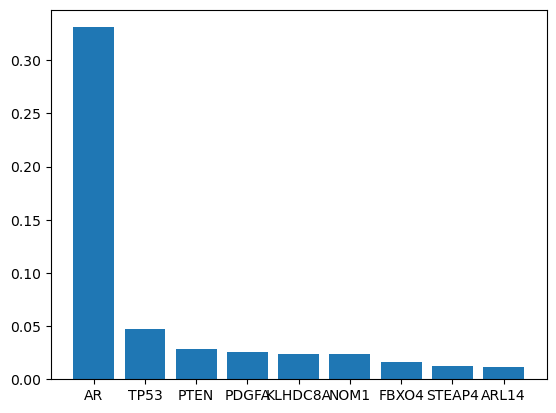

In [62]:
run=1
top_rank_run1 = bdt_gene_imps[run].rank(ascending=False).sort_values().index[:10]
plt.bar([i.split('_')[0] for i in top_rank_run1], bdt_gene_imps[run].loc[top_rank_run1])
plt.show()

In [21]:
# TODO: create sorted DF across all runs
for i in range(len(bdt_gene_imps)):
    print(f"Run {i}")
    print(bdt_gene_imps[i].rank(ascending=False).sort_values()[:10])
    print("\n")

Run 0
AR_somatic_amp          1.0
AR_somatic_mut          2.0
TP53_somatic_mut        3.0
PTEN_somatic_del        4.0
PDGFA_somatic_amp       5.0
KLHDC8A_somatic_amp     6.0
NOM1_somatic_del        7.0
FBXO4_somatic_amp       8.0
STEAP4_somatic_mut      9.0
ARL14_somatic_mut      10.0
dtype: float64


Run 1
AR_somatic_amp          1.0
AR_somatic_mut          2.0
TP53_somatic_mut        3.0
PTEN_somatic_del        4.0
PDGFA_somatic_amp       5.0
KLHDC8A_somatic_amp     6.0
NOM1_somatic_del        7.0
FBXO4_somatic_amp       8.0
STEAP4_somatic_mut      9.0
ARL14_somatic_mut      10.0
dtype: float64


Run 2
AR_somatic_amp          1.0
AR_somatic_mut          2.0
TP53_somatic_mut        3.0
PTEN_somatic_del        4.0
PDGFA_somatic_amp       5.0
KLHDC8A_somatic_amp     6.0
NOM1_somatic_del        7.0
FBXO4_somatic_amp       8.0
ARL14_somatic_mut       9.0
STEAP4_somatic_mut     10.0
dtype: float64


Run 3
AR_somatic_amp          1.0
AR_somatic_mut          2.0
TP53_somatic_mut        3.0
P

In [ ]:
tmp_ranking = pd.DataFrame(rf_gene_imps).apply(lambda row: row.abs().rank(ascending=False), axis=1)
tmp_ranking.loc[:,['MDM4_somatic_mut', 'MDM4_somatic_amp', 'MDM4_somatic_del']]

,MDM4_somatic_mut,MDM4_somatic_amp,MDM4_somatic_del
0,5983.0,10702.0,10702.0
1,5989.0,2258.0,10676.5
2,4866.0,10702.0,10702.0
3,6308.0,1248.0,10673.5
4,6225.0,1075.0,10698.5
5,6376.0,1967.0,10718.5
6,10662.0,10662.0,10662.0
7,6561.0,368.0,10662.5
8,6398.0,202.0,10667.0
9,6565.0,556.0,10668.0


In [100]:
logging.info("Checking that both methods return the same result.")
pnet_rankings = stability_utils.make_perpatient_rankings_dfs(pnet_gene_imps)
print(pnet_rankings[0].loc[:,'MDM4'])
pnet_patient_0_rank = stability_utils.make_pnet_gene_ranking_df(pnet_gene_imps, 0)
pnet_patient_0_rank.loc[:,'MDM4']

# calc_stability_metric_on_runs_by_generank_df(rankings_df, n_top_genes)

2024-01-22 20:30:51 INFO     Checking that both methods return the same result.


0     10.0
1     46.0
2     23.0
3     13.0
4     26.0
5      8.0
6     47.0
7     28.0
8     10.0
9     26.0
10    10.0
11     5.0
12    13.0
13    36.0
14    10.0
15    63.0
16    46.0
17    55.0
18    66.0
19    20.0
Name: MDM4, dtype: float64


MO_1124    10.0
MO_1124    46.0
MO_1124    23.0
MO_1124    13.0
MO_1124    26.0
MO_1124     8.0
MO_1124    47.0
MO_1124    28.0
MO_1124    10.0
MO_1124    26.0
MO_1124    10.0
MO_1124     5.0
MO_1124    13.0
MO_1124    36.0
MO_1124    10.0
MO_1124    63.0
MO_1124    46.0
MO_1124    55.0
MO_1124    66.0
MO_1124    20.0
Name: MDM4, dtype: float64